<a href="https://colab.research.google.com/github/Ananya-S-Krishna/stroke-risk-predictor/blob/main/Early_Stroke_Risk_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install xgboost lightgbm shap imbalanced-learn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
import lightgbm as lgb
from imblearn.over_sampling import SMOTE, ADASYN
import shap
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving healthcare-dataset-stroke-data.csv to healthcare-dataset-stroke-data (1).csv


In [ ]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [ ]:
df.info()          # Check the number of rows and columns, data types, and non-null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [ ]:
df.describe()      # Get basic statistical details of numeric columns

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [ ]:
df.isnull().sum()      # Show number of missing values per column

,0
id,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,201


In [ ]:
df['bmi'].fillna(df['bmi'].mean(), inplace=True)  # Fill missing values in the 'bmi' column with its mean

In [ ]:
df['gender'].value_counts()          # Check what unique values exist in the 'gender' column

,count
gender,
Female,2994
Male,2115
Other,1


In [ ]:
df = df[df['gender'] != 'Other']    # Drop rows where gender is 'Other'

In [ ]:
df.drop('id', axis=1, inplace=True) # Drop the 'id' column from the dataset

In [ ]:
df.isnull().sum()                   # Confirm no missing values are left

,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,0
smoking_status,0


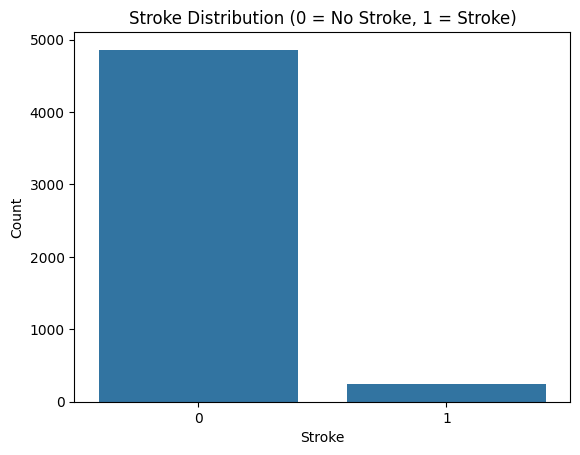

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the distribution of the target variable
sns.countplot(x='stroke', data=df)
plt.title('Stroke Distribution (0 = No Stroke, 1 = Stroke)')
plt.xlabel('Stroke')
plt.ylabel('Count')
plt.show()

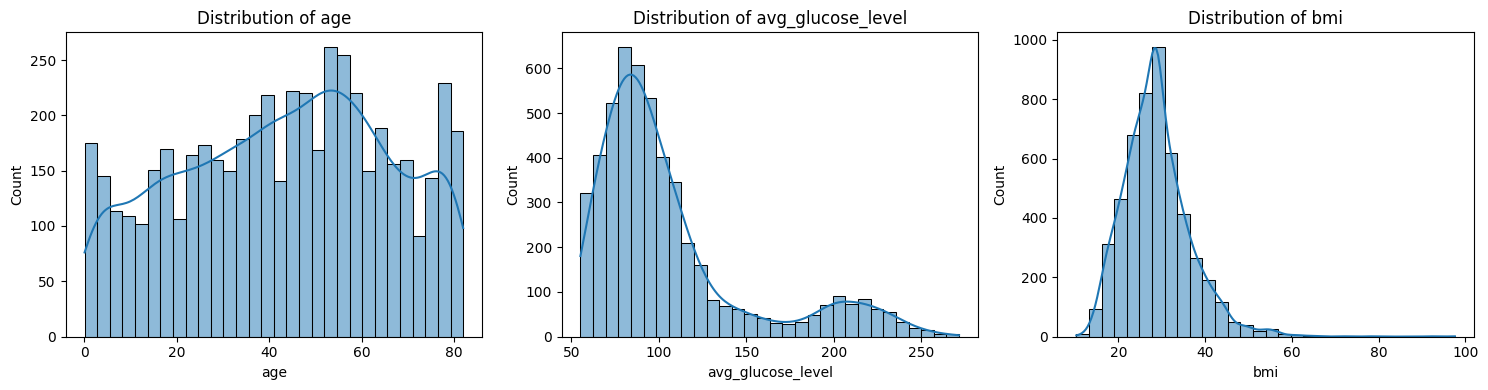

In [ ]:
numerical_cols = ['age', 'avg_glucose_level', 'bmi']

plt.figure(figsize=(15, 4))                             # Plot histograms for each numerical feature
for i, col in enumerate(numerical_cols):
    plt.subplot(1, 3, i + 1)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

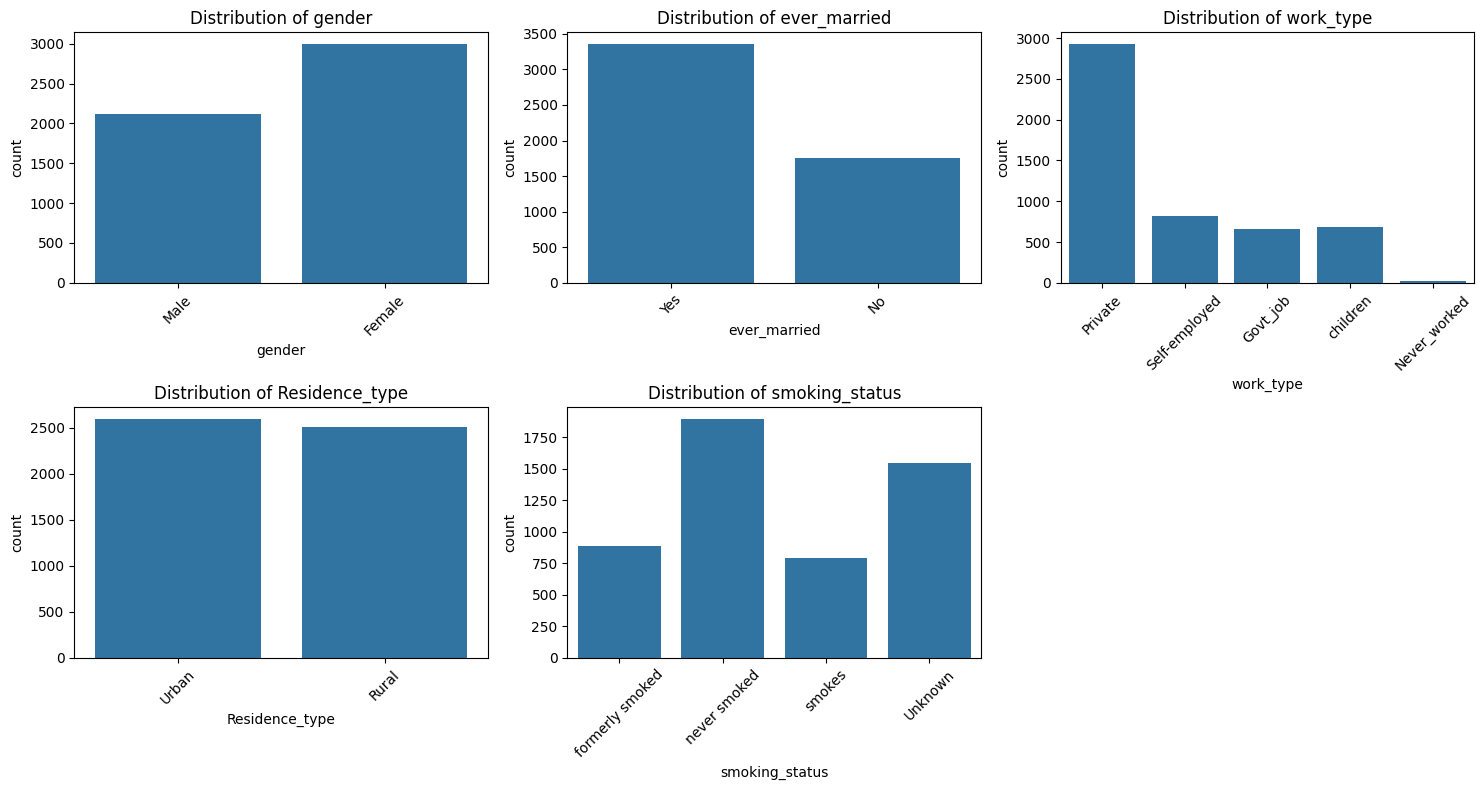

In [ ]:
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

plt.figure(figsize=(15, 8))                      # Set up subplots
for i, col in enumerate(categorical_cols):
    plt.subplot(2, 3, i + 1)
    sns.countplot(x=col, data=df)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

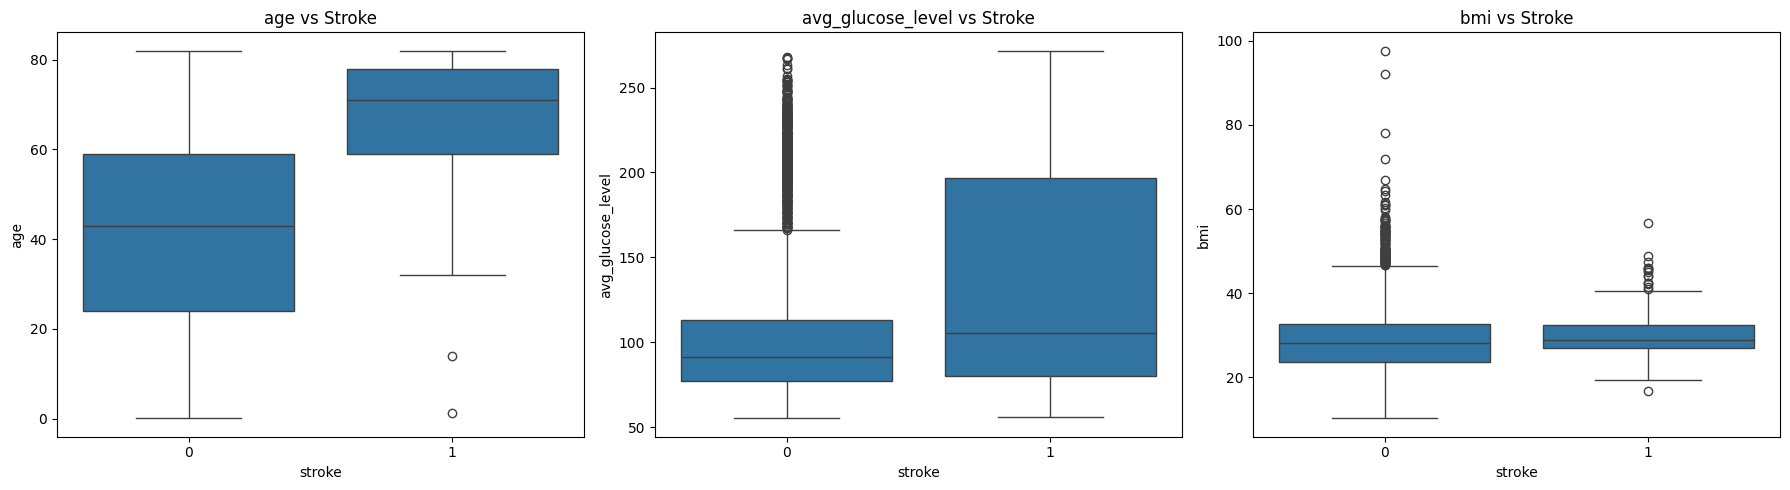

In [ ]:
num_cols = ['age', 'avg_glucose_level', 'bmi']     # Numerical columns

plt.figure(figsize=(18, 5))
for i, col in enumerate(num_cols):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(x='stroke', y=col, data=df)
    plt.title(f'{col} vs Stroke')
plt.tight_layout()
plt.show()

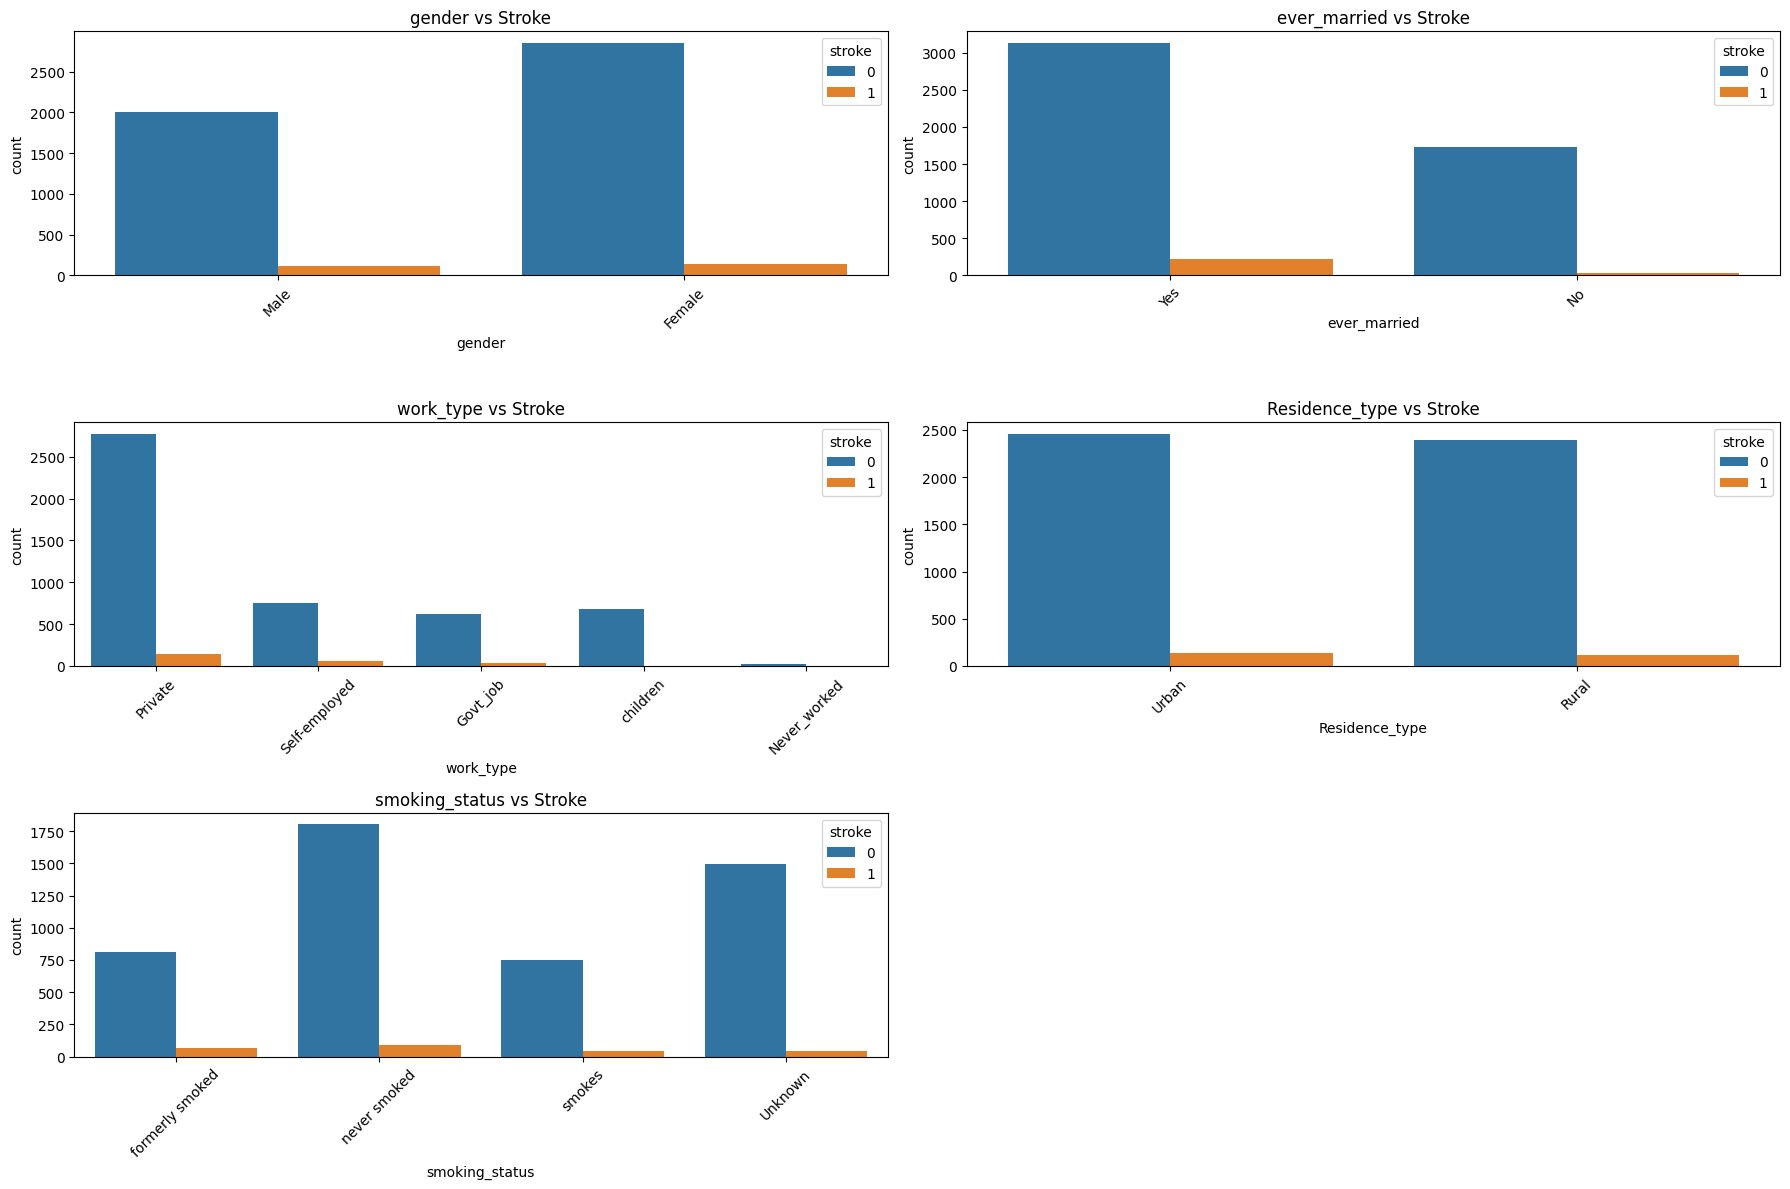

In [ ]:
import seaborn as sns                               # Import visualization libraries
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 12))                        # Set plot size

categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'] # List of categorical columns to analyze

for idx, col in enumerate(categorical_cols, 1):     # Plot each category vs stroke
    plt.subplot(3, 2, idx)
    sns.countplot(x=col, hue='stroke', data=df)
    plt.title(f"{col} vs Stroke")
    plt.xticks(rotation=45)
    plt.tight_layout()
plt.show()

In [ ]:
df.select_dtypes(include='object').columns #Returns all columns that are non-numeric

Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object')

In [ ]:
# Label Encoding for binary categorical features
df['gender'] = df['gender'].map({'Male': 0, 'Female': 1})
df['ever_married'] = df['ever_married'].map({'No': 0, 'Yes': 1})
df['Residence_type'] = df['Residence_type'].map({'Rural': 0, 'Urban': 1})

In [ ]:
# One-Hot Encoding for work_type and smoking_status
df = pd.get_dummies(df, columns=['work_type', 'smoking_status'], drop_first=True)
#drop_first=True avoids multicollinearity by dropping the first category in each column.

In [ ]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0,67.0,0,1,1,1,228.69,36.600000,1,False,True,False,False,True,False,False
1,1,61.0,0,0,1,0,202.21,28.893237,1,False,False,True,False,False,True,False
2,0,80.0,0,1,1,0,105.92,32.500000,1,False,True,False,False,False,True,False
3,1,49.0,0,0,1,1,171.23,34.400000,1,False,True,False,False,False,False,True
4,1,79.0,1,0,1,0,174.12,24.000000,1,False,False,True,False,False,True,False


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()                               # Create a scaler instance
scale_cols = ['age', 'avg_glucose_level', 'bmi']        # List of columns to scale
df[scale_cols] = scaler.fit_transform(df[scale_cols])   # Apply scaler to those columns and update the DataFrame
df.head()                                               # Check result

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0,1.051242,0,1,1,1,2.706450,1.001041,1,False,True,False,False,True,False,False
1,1,0.785889,0,0,1,0,2.121652,-0.000165,1,False,False,True,False,False,True,False
2,0,1.626174,0,1,1,0,-0.004867,0.468399,1,False,True,False,False,False,True,False
3,1,0.255182,0,0,1,1,1.437473,0.715233,1,False,True,False,False,False,False,True
4,1,1.581949,1,0,1,0,1.501297,-0.635858,1,False,False,True,False,False,True,False


In [ ]:
!pip install imbalanced-learn

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

In [ ]:
# Separate features and target
X = df.drop('stroke', axis=1)
y = df['stroke']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)         # preserves imbalance ratio in test set

In [ ]:
#Apply SMOTE on Training Data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [ ]:
# Before SMOTE
print("Before SMOTE:", y_train.value_counts())
# After SMOTE
print("After SMOTE:", y_train_smote.value_counts())

Before SMOTE: stroke
0    3888
1     199
Name: count, dtype: int64
After SMOTE: stroke
0    3888
1    3888
Name: count, dtype: int64


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Initialize models
logreg = LogisticRegression(random_state=42)
dt = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)

# Fit models on SMOTE-balanced training data
logreg.fit(X_train_smote, y_train_smote)
dt.fit(X_train_smote, y_train_smote)
rf.fit(X_train_smote, y_train_smote)

RandomForestClassifier(random_state=42)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Make predictions on the test set (not SMOTE-balanced)
models = {'Logistic Regression': logreg,
          'Decision Tree': dt,
          'Random Forest': rf}

for name, model in models.items():
    print(f"\n----- {name} -----")
    y_pred = model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))
    print("Classification Report:\n", classification_report(y_test, y_pred))


----- Logistic Regression -----
Accuracy: 0.7651663405088063
ROC-AUC: 0.8251440329218107
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.77      0.86       972
           1       0.14      0.74      0.24        50

    accuracy                           0.77      1022
   macro avg       0.56      0.75      0.55      1022
weighted avg       0.94      0.77      0.83      1022


----- Decision Tree -----
Accuracy: 0.8679060665362035
ROC-AUC: 0.5890740740740741
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.90      0.93       972
           1       0.12      0.28      0.17        50

    accuracy                           0.87      1022
   macro avg       0.54      0.59      0.55      1022
weighted avg       0.92      0.87      0.89      1022


----- Random Forest -----
Accuracy: 0.8864970645792564
ROC-AUC: 0.7687139917695474
Classification Report:
               pr

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid_lr = {                                              # Define the parameter grid
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],                                   # supports both l1 and l2
}

grid_lr = GridSearchCV(LogisticRegression(random_state=42),    # Set up GridSearchCV
                       param_grid=param_grid_lr,
                       scoring='f1',                           # Focused on improving F1-score
                       cv=5,
                       n_jobs=-1)

grid_lr.fit(X_train_smote, y_train_smote)                      # Fit on SMOTE-balanced training data
print("Best Parameters:", grid_lr.best_params_)                # Best parameters and model
best_logreg = grid_lr.best_estimator_

Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Predict on original (imbalanced) test set
y_pred_tuned = best_logreg.predict(X_test)
y_proba_tuned = best_logreg.predict_proba(X_test)[:, 1]

# Evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred_tuned))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_tuned))
print("Classification Report:\n", classification_report(y_test, y_pred_tuned))

Accuracy: 0.7651663405088063
ROC-AUC: 0.8252880658436215
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.77      0.86       972
           1       0.14      0.74      0.24        50

    accuracy                           0.77      1022
   macro avg       0.56      0.75      0.55      1022
weighted avg       0.94      0.77      0.83      1022



In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid_rf = {                                                 # Parameter grid for tuning
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'class_weight': [None, 'balanced']
}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42),   # GridSearchCV setup
                       param_grid=param_grid_rf,
                       scoring='f1',
                       cv=5,
                       n_jobs=-1)
grid_rf.fit(X_train_smote, y_train_smote)                         # Fit on SMOTE-balanced data
print("Best Parameters:", grid_rf.best_params_)                   # Best model
best_rf = grid_rf.best_estimator_

Best Parameters: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Predict on original test set
y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

Accuracy: 0.8874755381604696
ROC-AUC: 0.7636419753086421
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.92      0.94       972
           1       0.13      0.22      0.16        50

    accuracy                           0.89      1022
   macro avg       0.54      0.57      0.55      1022
weighted avg       0.92      0.89      0.90      1022



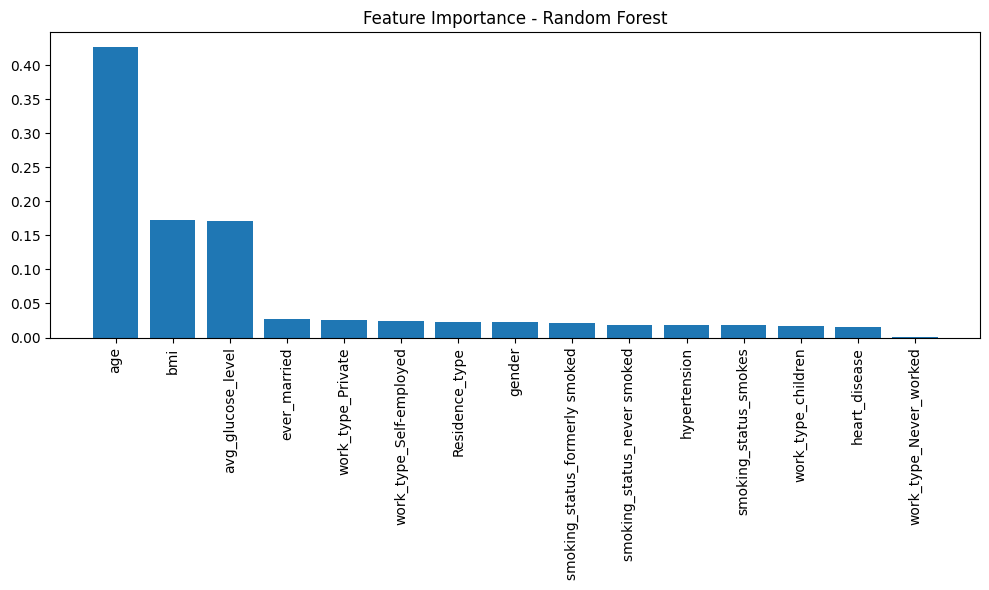

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

importances = best_rf.feature_importances_                                     # Get feature importances
features = X_train.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))                                                    # Plot
plt.title("Feature Importance - Random Forest")
plt.bar(range(len(features)), importances[indices], align="center")
plt.xticks(range(len(features)), [features[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Train the model
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)

# Predict
y_pred = xgb.predict(X_test)
y_proba = xgb.predict_proba(X_test)[:, 1]

# Evaluation
print("----- XGBoost -----")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("Classification Report:\n", classification_report(y_test, y_pred))

----- XGBoost -----
Accuracy: 0.9412915851272016
ROC-AUC: 0.7894032921810699
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       972
           1       0.19      0.06      0.09        50

    accuracy                           0.94      1022
   macro avg       0.57      0.52      0.53      1022
weighted avg       0.92      0.94      0.93      1022



<Figure size 1000x800 with 0 Axes>

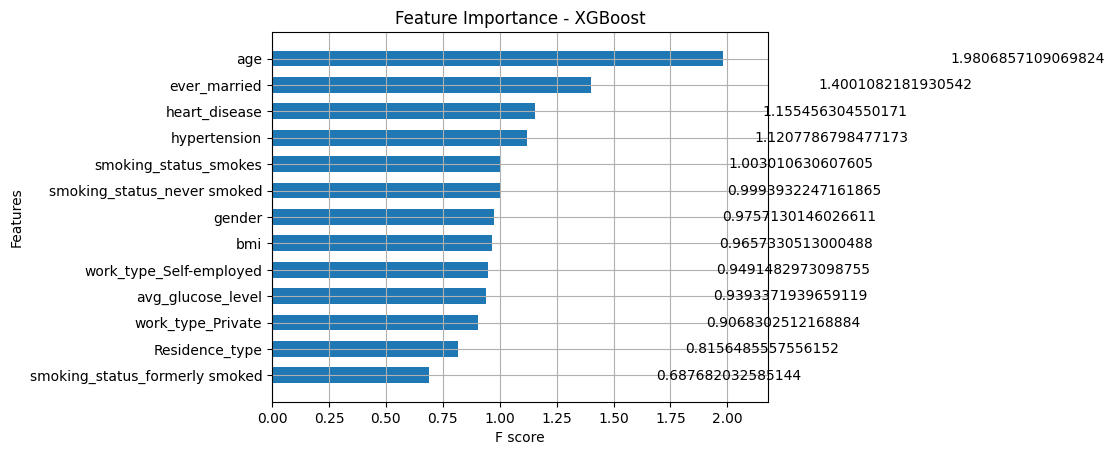

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Plot feature importance (built-in XGBoost utility)
plt.figure(figsize=(10, 8))
plot_importance(xgb, max_num_features=15, importance_type='gain', height=0.6)
plt.title("Feature Importance - XGBoost")
plt.show()

In [ ]:
import joblib

# Save
joblib.dump(grid_lr.best_estimator_, "logistic_regression_stroke_model.pkl")

# Load
loaded_model = joblib.load("logistic_regression_stroke_model.pkl")
prediction = loaded_model.predict(X_test.iloc[0:1])
print("Predicted stroke risk:", prediction)

Predicted stroke risk: [0]


In [ ]:
joblib.dump(best_rf, "random_forest_stroke_model.pkl")

['random_forest_stroke_model.pkl']

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import joblib

# Train the XGBoost model
best_xgb = xgb.XGBClassifier(random_state=42)
best_xgb.fit(X_train, y_train)

# Predict and evaluate (optional, you already have this)
y_pred = best_xgb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Save the model
joblib.dump(best_xgb, "xgboost_stroke_model.pkl")

Accuracy: 0.9412915851272016
ROC-AUC: 0.523312757201646
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       972
           1       0.19      0.06      0.09        50

    accuracy                           0.94      1022
   macro avg       0.57      0.52      0.53      1022
weighted avg       0.92      0.94      0.93      1022



['xgboost_stroke_model.pkl']

In [ ]:
import joblib

joblib.dump(scaler, "scaler.pkl")                             # Save the StandardScaler
joblib.dump(X_train.columns.tolist(), "model_features.pkl")   # Optional: save the list of final features used by the model

['model_features.pkl']

In [ ]:
import numpy as np
import pandas as pd
import joblib

def predict_stroke_risk(input_data: dict):
    model = joblib.load("xgboost_stroke_model.pkl")                     # Load the trained model, scaler, and feature list
    scaler = joblib.load("scaler.pkl")
    model_features = joblib.load("model_features.pkl")

    input_df = pd.DataFrame([input_data])                               # Convert input dictionary to DataFrame
    input_df = pd.get_dummies(input_df)                                 # One-hot encode categorical variables

    input_df = input_df.reindex(columns=model_features, fill_value=0)   # Align the input with model features
    input_scaled = scaler.transform(input_df)                           # Scale the data
    prediction = model.predict(input_scaled)                            # Predict
    return prediction

In [ ]:
import joblib
model_features = joblib.load("model_features.pkl")
print(model_features)

['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type', 'avg_glucose_level', 'bmi', 'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes']


In [ ]:
import pandas as pd
import joblib

# Load model and feature names
model = joblib.load("xgboost_stroke_model.pkl")
features = joblib.load("model_features.pkl")

# Create input sample (MATCHING FINAL FEATURE NAMES ONLY)
sample = {
    'gender': 1,
    'age': 67.0,
    'hypertension': 0,
    'heart_disease': 1,
    'ever_married': 1,
    'Residence_type': 1,
    'avg_glucose_level': 228.69,
    'bmi': 36.6,
    'work_type_Never_worked': 0,
    'work_type_Private': 1,
    'work_type_Self-employed': 0,
    'work_type_children': 0,
    'smoking_status_formerly smoked': 1,
    'smoking_status_never smoked': 0,
    'smoking_status_smokes': 0
}

# Convert to DataFrame with matching order
sample_df = pd.DataFrame([sample])[features]  # This ensures correct order

# Predict
prediction = model.predict(sample_df)
print("Predicted stroke risk:", prediction)

Predicted stroke risk: [0]
